In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, jaccard_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os
from skimage.feature import graycomatrix, graycoprops

Анализ текстурных характеристик изображений с использованием гистограммных, Laws и GLCM признаков

Размер данных: (810, 10)
Количество классов: 10


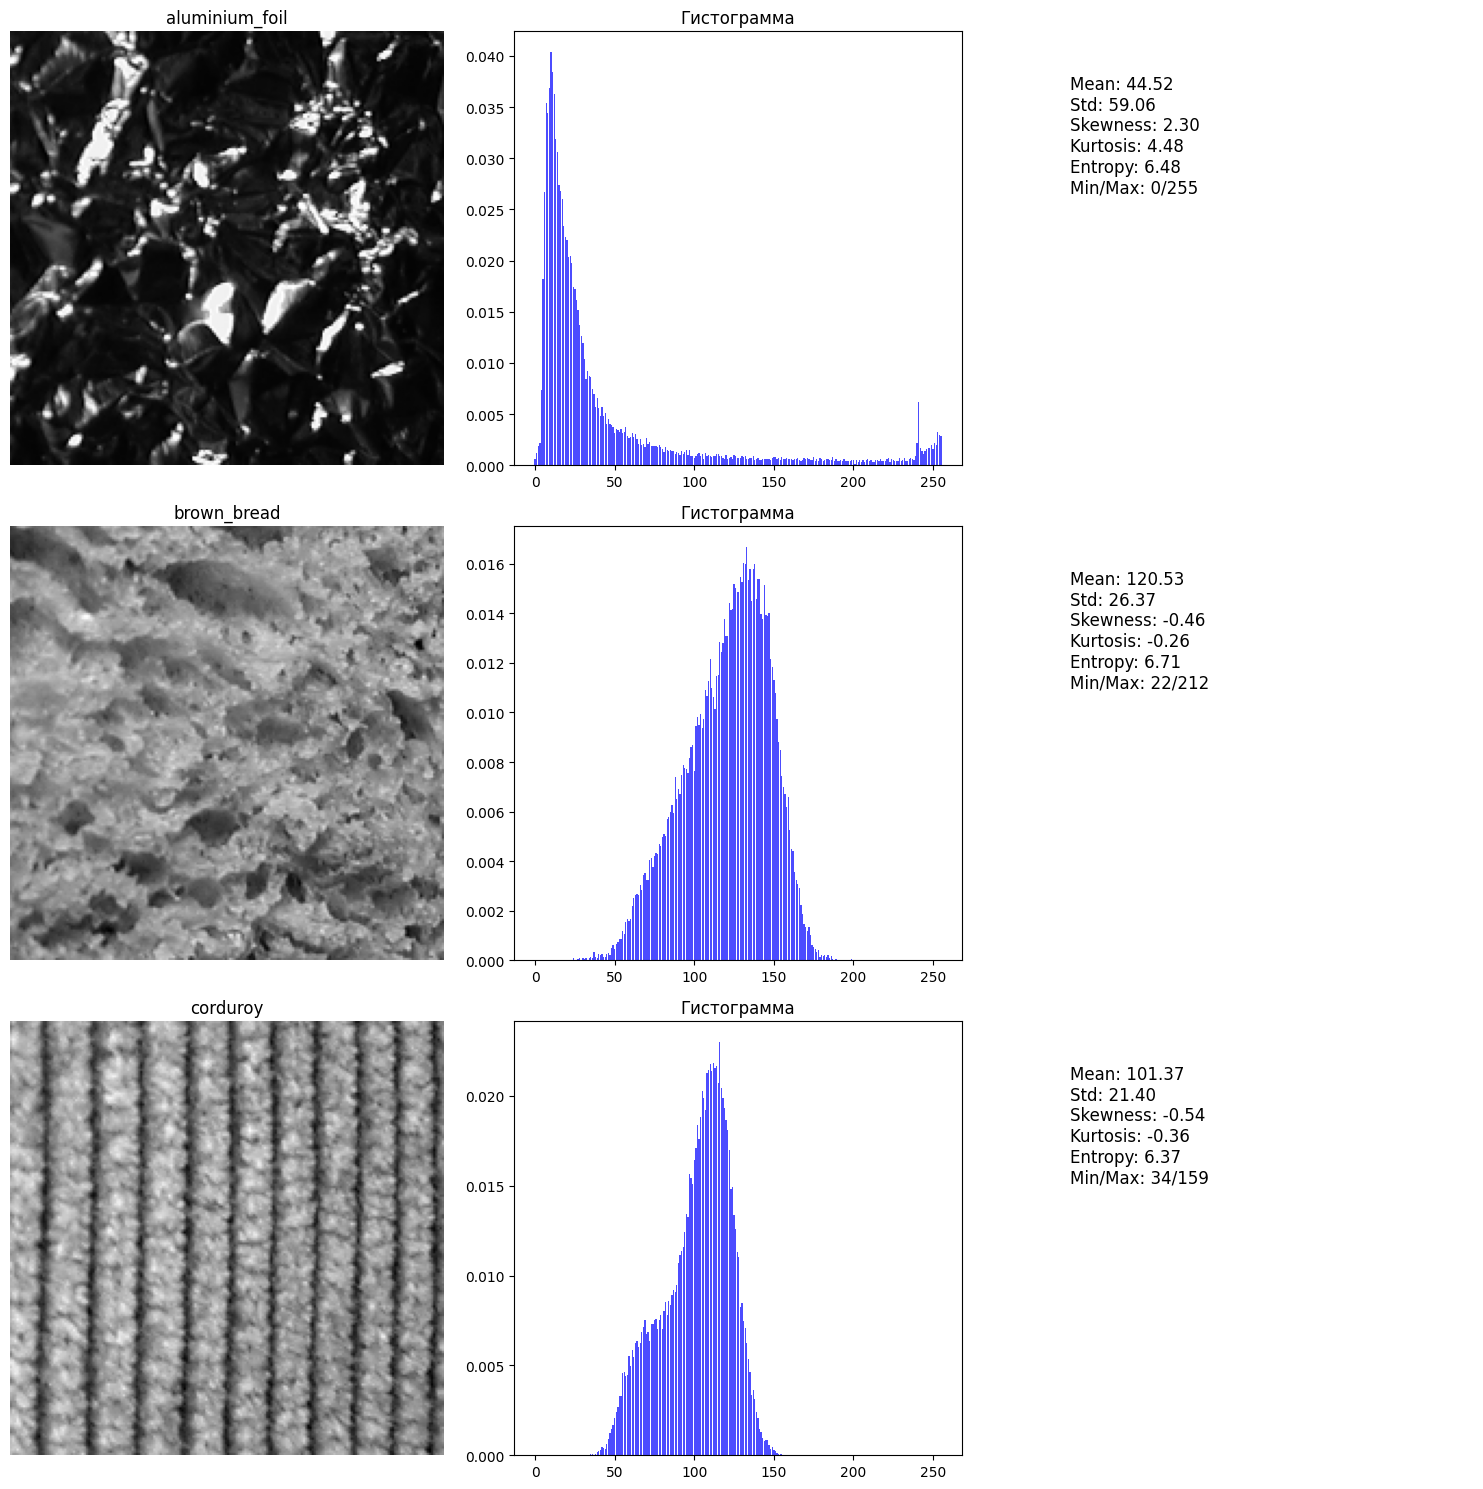

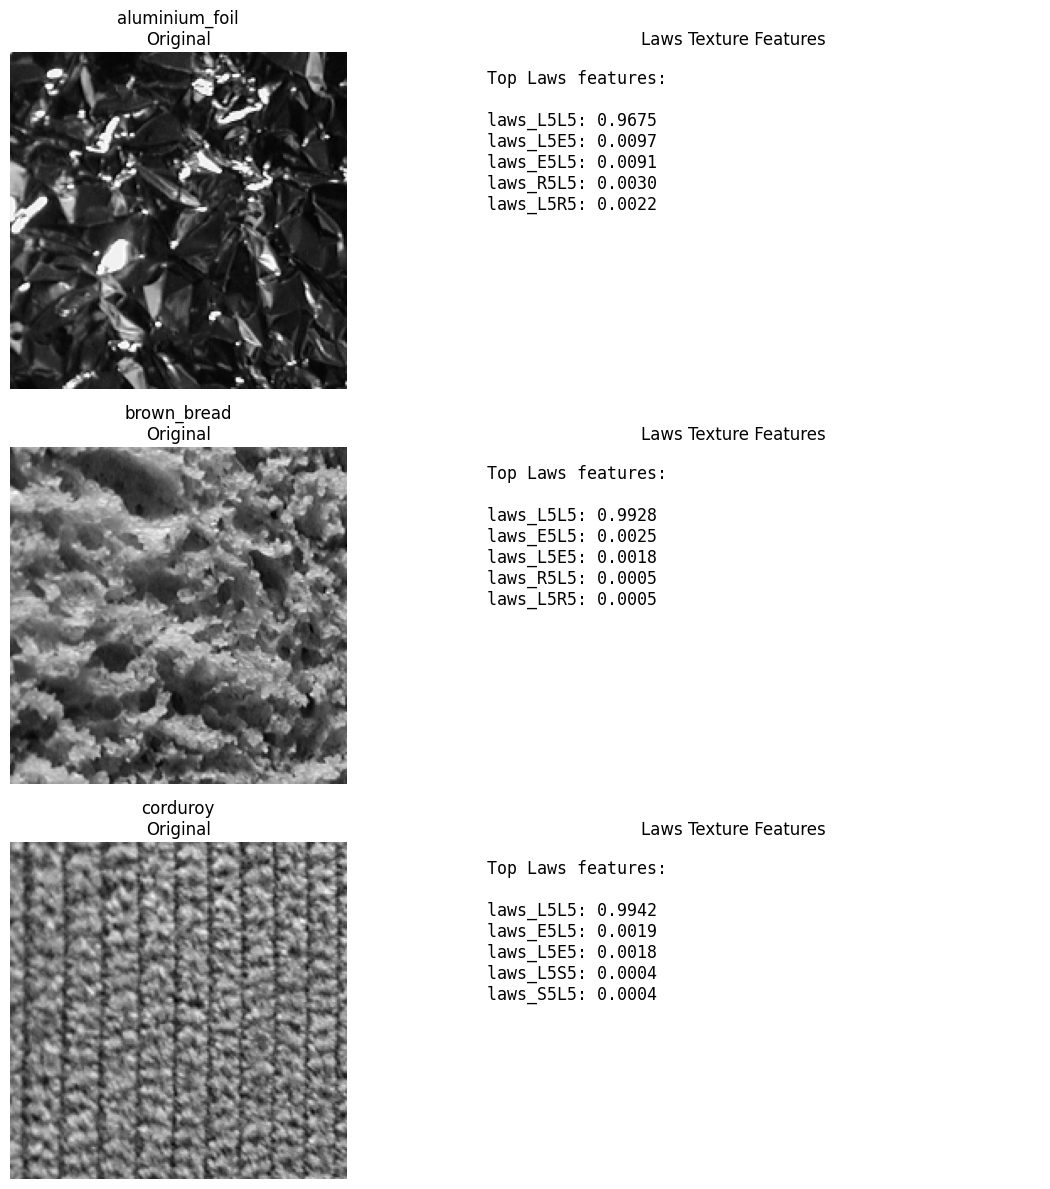

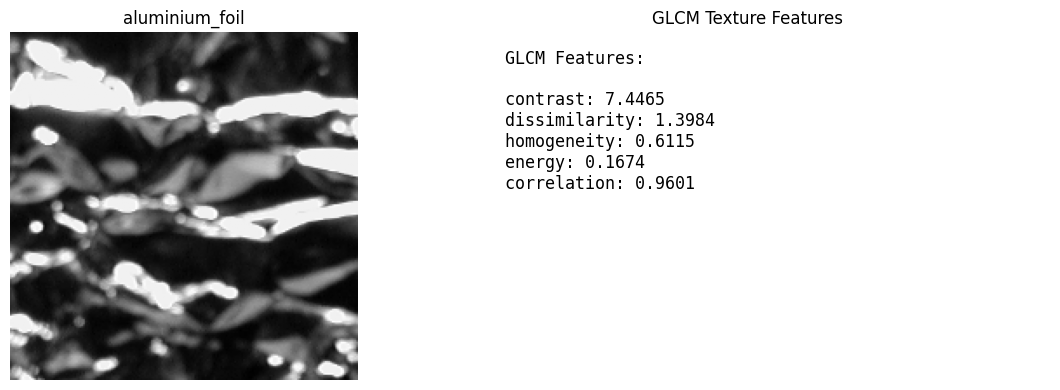

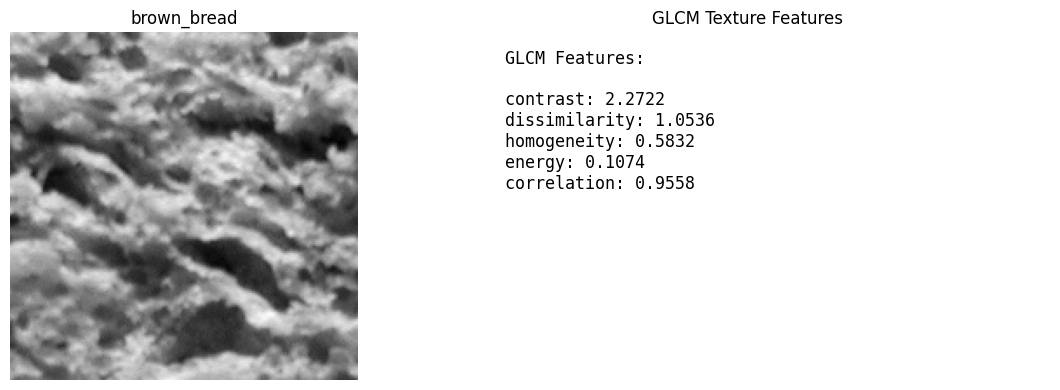

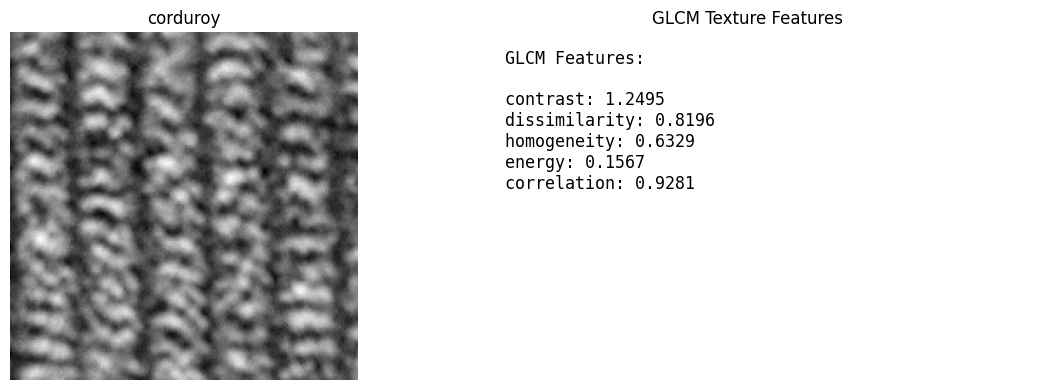

In [57]:
def load_texture_data_with_stats(image_folder):
    data = []
    labels = []
    
    for texture_name in os.listdir(image_folder):
        texture_path = os.path.join(image_folder, texture_name)
        
        if os.path.isdir(texture_path):
            for image_file in os.listdir(texture_path):
                image_path = os.path.join(texture_path, image_file)
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    features = extract_histogram_features(image)
                    data.append(features)
                    labels.append(texture_name)
    
    return np.array(data), np.array(labels)

def compute_histogram(gray_image, bins=256):
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()
    
    values = np.arange(bins)
    features = {}
    
    features['mean'] = np.sum(hist * values)
    
    variance = np.sum(hist * (values - features['mean'])**2)
    features['std'] = np.sqrt(variance)
    
    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std'])**3)
    else:
        features['skewness'] = 0
    
    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std'])**4) - 3
    else:
        features['kurtosis'] = -3
    
    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))
    
    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25) 
    features['q2'] = np.argmax(cumulative_hist >= 0.5)  
    features['q3'] = np.argmax(cumulative_hist >= 0.75) 
    
    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255
    
    return features, hist

def extract_histogram_features(gray_image, bins=256):
    hist = None
    stats_dict, hist = compute_histogram(gray_image, bins)
    
    features = [
        stats_dict['mean'],
        stats_dict['std'],
        stats_dict['skewness'],
        stats_dict['kurtosis'],
        stats_dict['entropy'],
        stats_dict['q1'],
        stats_dict['q2'], 
        stats_dict['q3'],
        stats_dict['min'],
        stats_dict['max']
    ]
    
    return np.array(features)

image_folder = "./textures_dataset"
data, labels = load_texture_data_with_stats(image_folder)

print(f"Размер данных: {data.shape}") 
print(f"Количество классов: {len(np.unique(labels))}")

def example_plot_texture(image_folder, num_examples):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 3:
            image_path = os.path.join(texture_path, image_files[3])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                features, hist = compute_histogram(image)
                
                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'{texture_name}')
                axes[i, 0].axis('off')
                
                axes[i, 1].bar(range(256), hist, alpha=0.7, color='blue')
                axes[i, 1].set_title('Гистограмма')
                
                metrics_text = (
                    f"Mean: {features['mean']:.2f}\n"
                    f"Std: {features['std']:.2f}\n"
                    f"Skewness: {features['skewness']:.2f}\n"
                    f"Kurtosis: {features['kurtosis']:.2f}\n"
                    f"Entropy: {features['entropy']:.2f}\n"
                    f"Min/Max: {features['min']}/{features['max']}"
                )
                
                axes[i, 2].text(0.1, 0.9, metrics_text, transform=axes[i, 2].transAxes, fontsize=12, verticalalignment='top')
                axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

example_plot_texture(image_folder, num_examples=3)

def laws_texture_features(image, normalize=True):
    L5 = np.array([1,  4,  6,  4,  1])
    E5 = np.array([-1, -2,  0,  2,  1])
    S5 = np.array([-1,  0,  2,  0, -1])
    W5 = np.array([-1,  2,  0, -2,  1])
    R5 = np.array([1,  -4,  6, -4,  1])
    
    masks_1d = [L5, E5, S5, W5, R5]
    masks_names = ['L5', 'E5', 'S5', 'W5', 'R5']
    
    filters_2d = []
    filter_names = []
    
    for i, mask1 in enumerate(masks_1d):
        for j, mask2 in enumerate(masks_1d):
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
            filter_names.append(f"{masks_names[i]}{masks_names[j]}")
    
    features = []
    feature_names = []
    
    for kernel, name in zip(filters_2d, filter_names):
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
        feature_names.append(f"laws_{name}")
    
    features = np.array(features)
    
    if normalize and np.sum(features) > 0:
        features = features / np.sum(features)
    
    return features, feature_names

def example_plot_laws(image_folder, num_examples=3):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4*num_examples))
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 5:
            image_path = os.path.join(texture_path, image_files[5])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                features, names = laws_texture_features(image)
                
                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'{texture_name}\nOriginal')
                axes[i, 0].axis('off')
                
                top_indices = np.argsort(features)[-5:][::-1]
                laws_text = "Top Laws features:\n\n"
                for j, idx in enumerate(top_indices):
                    laws_text += f"{names[idx]}: {features[idx]:.4f}\n"
                
                axes[i, 1].text(0.1, 0.95, laws_text, transform=axes[i, 1].transAxes, 
                                fontsize=12, verticalalignment='top', fontfamily='monospace')
                axes[i, 1].set_title('Laws Texture Features')
                axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

example_plot_laws(image_folder, num_examples=3)

def compute_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image = (image // 8).astype(np.uint8)
    
    glcm = graycomatrix(image, distances=distances, angles=angles, 
                       levels=32, symmetric=True, normed=True)
    
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)
    
    return np.array(features)

def example_plot_glcm(image_folder, num_examples=3):
    texture_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    
    for i in range(min(num_examples, len(texture_folders))):
        texture_name = texture_folders[i]
        texture_path = os.path.join(image_folder, texture_name)
        
        image_files = [f for f in os.listdir(texture_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 2:
            image_path = os.path.join(texture_path, image_files[2])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                features = compute_glcm_features(image)
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.imshow(image, cmap='gray')
                plt.title(f'{texture_name}')
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                
                glcm_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
                glcm_text = "GLCM Features:\n\n"
                for name, value in zip(glcm_names, features):
                    glcm_text += f"{name}: {value:.4f}\n"
                
                plt.text(0.1, 0.95, glcm_text, transform=plt.gca().transAxes, 
                        fontsize=12, verticalalignment='top', fontfamily='monospace')
                plt.axis('off')
                plt.title('GLCM Texture Features')
                
                plt.tight_layout()
                plt.show()

example_plot_glcm(image_folder, num_examples=3)

Загрузка и подготовка данных для обучения

In [58]:
image_paths = []
for class_folder in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, file))

print(f"Найдено {len(image_paths)} изображений")

X_hist = []  
X_laws = []  
X_glcm = []  
y = []      

for i, path in enumerate(image_paths):
    if i % 100 == 0:
        print(f"Обработано {i}/{len(image_paths)} изображений")
    
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
        
        hist_features    = extract_histogram_features(image)  
        laws_features, _ = laws_texture_features(image)    
        glcm_features    = compute_glcm_features(image)       
        
        X_hist.append(hist_features)
        X_laws.append(laws_features)
        X_glcm.append(glcm_features)
        
        label = os.path.basename(os.path.dirname(path))
        y.append(label)

X_hist = np.array(X_hist)
X_laws = np.array(X_laws) 
X_glcm = np.array(X_glcm)
y = np.array(y)

print(f"Размер данных: {X_hist.shape}")
print(f"Количество классов: {len(np.unique(y))}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

methods = {
    'Histogram': X_hist,
    'Laws': X_laws, 
    'GLCM': X_glcm
}

models = {
    'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),  
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
}

trained_models = {}

for method_name, X in methods.items():
    print(f"\n{method_name.upper()}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    method_models = {}
    
    for model_name, model_template in models.items():
        if model_name == 'kNN':
            model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif model_name == 'SVM':
            model = SVC(kernel='rbf', random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(random_state=42, max_depth=10)
        
        if model_name == 'SVM':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            method_models[model_name] = (model, scaler)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            method_models[model_name] = model
        
        print(f"{model_name}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        print()
    
    trained_models[method_name] = method_models

selected_models = {
    'Histogram_kNN': trained_models['Histogram']['kNN'],  
    'Laws_Tree': trained_models['Laws']['DecisionTree'],                      
    'Laws_SVM': trained_models['Laws']['SVM']                                     
}

Найдено 810 изображений
Обработано 0/810 изображений
Обработано 100/810 изображений
Обработано 200/810 изображений
Обработано 300/810 изображений
Обработано 400/810 изображений
Обработано 500/810 изображений
Обработано 600/810 изображений
Обработано 700/810 изображений
Обработано 800/810 изображений
Размер данных: (810, 10)
Количество классов: 10

HISTOGRAM
kNN
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_bread       0.90      0.95      0.93        20
      corduroy       0.58      0.70      0.64        20
        cotton       0.55      0.52      0.54        21
       cracker       0.83      0.71      0.77        21
         linen       0.76      0.65      0.70        20
   orange_peel       0.94      0.76      0.84        21
     sandpaper       0.39      0.35      0.37        20
        sponge       0.64      0.80      0.71        20
     styrofoam       0.91      1.00      0.95        20

      accuracy    

In [59]:
def segment_sandwich(model_info, model_name, image_path, patch_size=32, step=16, n_classes=4):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return None
    
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)

    all_predictions = []
    
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            
            if isinstance(model_info, tuple):  
                model, scaler = model_info
                features_scaled = scaler.transform(features.reshape(1, -1))
                pred_class = model.predict(features_scaled)[0]
            else:  
                model = model_info
                pred_class = model.predict(features.reshape(1, -1))[0]
            
            seg_map[y:y+patch_size, x:x+patch_size] = pred_class
            all_predictions.append(pred_class)

    unique, counts = np.unique(all_predictions, return_counts=True)
    
    top_classes = unique[np.argsort(counts)[-n_classes:]]
    
    seg_map_filtered = np.zeros_like(seg_map)
    
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    mask_not_in_top = ~np.isin(seg_map, top_classes)
    if np.any(mask_not_in_top):
        seg_map_filtered[mask_not_in_top] = 1 
    
    print(f"Уникальные классы после фильтрации: {np.unique(seg_map_filtered)}")
    
    return seg_map_filtered
rails_image_path = "./images/rails_texture.png"
original_img = cv2.imread(rails_image_path, cv2.IMREAD_GRAYSCALE)

СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ РАЗНЫМИ МОДЕЛЯМИ

   Обрабатываем: Histogram_kNN
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно
   Обрабатываем: Laws_Tree
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно
   Обрабатываем: Laws_SVM
Уникальные классы после фильтрации: [0 1 2 3]
   Успешно


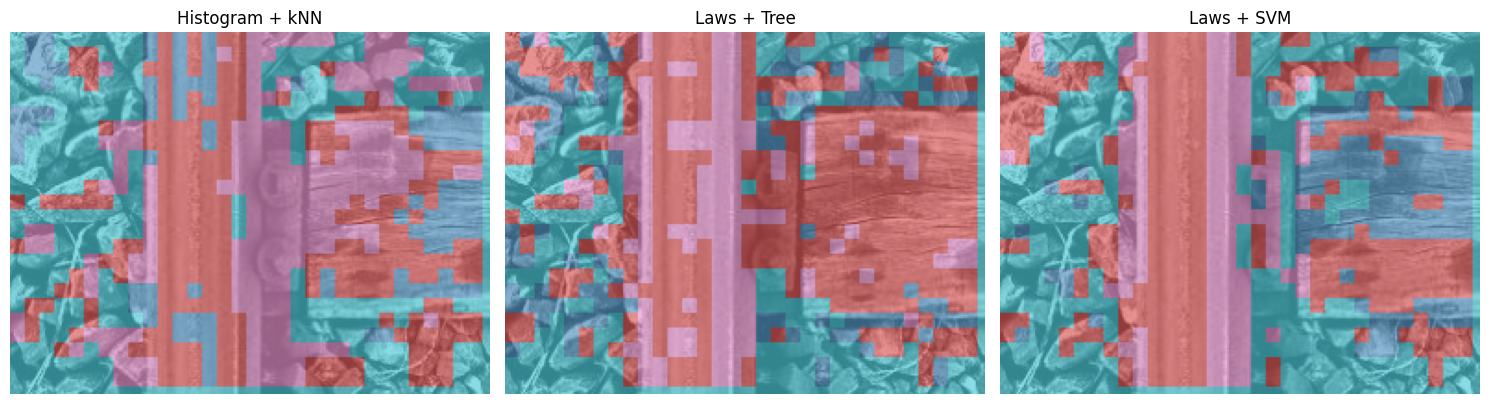


Обработано моделей: 3/3


In [60]:
if original_img is not None:
    seg_maps = []
    model_names = []
    
    for model_name, model_info in selected_models.items():
        print(f"   Обрабатываем: {model_name}")
        
        seg_result = segment_sandwich(model_info, model_name, rails_image_path,
                                    patch_size=16, step=8)
        
        if seg_result is not None:
            seg_maps.append(seg_result)
            model_names.append(model_name)
            print(f"   Успешно")
        else:
            print(f"   Ошибка")
    if seg_maps:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, (seg_map, model_name) in enumerate(zip(seg_maps, model_names)):
            if 'Histogram' in model_name:
                method = 'Histogram'
                model_type = 'kNN'
            elif 'Laws' in model_name:
                method = 'Laws'
                if 'Tree' in model_name:
                    model_type = 'Tree'
                else:
                    model_type = 'SVM'
            
            axes[i].imshow(original_img, cmap='gray', alpha=0.7)
            axes[i].imshow(seg_map, cmap='tab10', alpha=0.5)
            axes[i].set_title(f'{method} + {model_type}', fontsize=12)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nОбработано моделей: {len(seg_maps)}/3")
    else:
        print("Ни одна модель не вернула результат!")
else:
    print(f"Не удалось загрузить изображение: {rails_image_path}")

ПОДГОТОВКА РУЧНОЙ РАЗМЕТКИ ДЛЯ ОЦЕНКИ

In [61]:
def keep_top_colors(mask, n_colors=4):
    if mask is None:
        print("Маска не загружена, создаем тестовую...")
        mask = np.zeros((256, 256), dtype=np.uint8)
        mask[0:128, 0:128] = 0
        mask[0:128, 128:256] = 1  
        mask[128:256, 0:128] = 2
        mask[128:256, 128:256] = 3
    
    unique, counts = np.unique(mask, return_counts=True)
    
    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]
    
    print(f"Топ-{n_colors} самых частых цветов: {top_colors}")
    print(f"Их частоты: {counts[sorted_indices[:n_colors]]}")
    
    result = np.zeros_like(mask)
    
    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value
    
    print(f"Перенумеровано: {top_colors} -> {list(range(len(top_colors)))}")
    
    return result

ЗАГРУЗКА И ПРЕДОБРАБОТКА РУЧНОЙ РАЗМЕТКИ

In [62]:
manual_mask_path = "./images/rails_manual_mask.png"
manual_mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)
fixed_manual_mask = keep_top_colors(manual_mask, n_colors=4)

Топ-4 самых частых цветов: [123  84  91 124]
Их частоты: [21426 12600 10784   737]
Перенумеровано: [123  84  91 124] -> [0, 1, 2, 3]


ВИЗУАЛИЗАЦИЯ РУЧНОЙ РАЗМЕТКИ

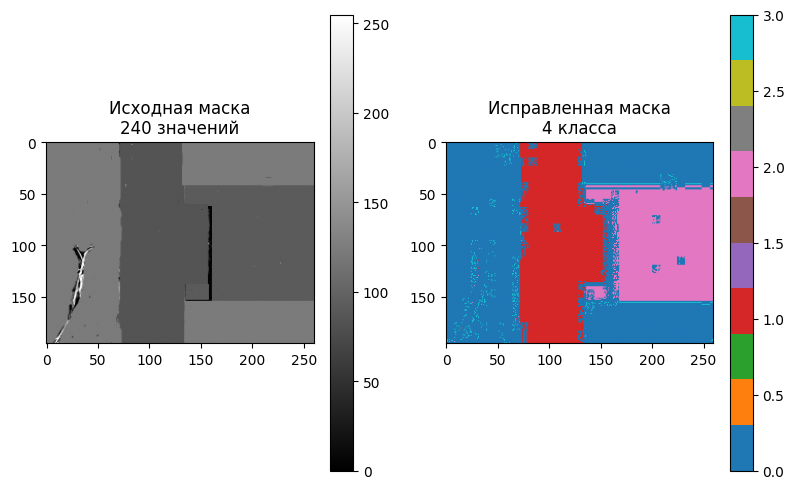

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(manual_mask, cmap='gray')
plt.title(f'Исходная маска\n{len(np.unique(manual_mask))} значений')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(fixed_manual_mask, cmap='tab10')
plt.title('Исправленная маска\n4 класса')
plt.colorbar()

plt.tight_layout()
plt.show()

ФУНКЦИЯ ОЦЕНКИ КАЧЕСТВА СЕГМЕНТАЦИИ

In [64]:
def compare_simple(manual_mask, predicted_mask, model_name, original_img):
    
    predicted_resized = predicted_mask
    
    manual_classes = np.unique(manual_mask)
    pred_classes = np.unique(predicted_resized)
    
    print(f"Классы в ручной разметке: {manual_classes}")
    print(f"Классы в предсказании: {pred_classes}")
    
    class_mapping = {
        0: 3,  
        1: 2,  
        2: 1,    
        3: 0   
    }
    
    pred_mapped = predicted_resized.copy()
    for pred_class, manual_class in class_mapping.items():
        pred_mapped[predicted_resized == pred_class] = manual_class
    
    accuracy = accuracy_score(manual_mask.flatten(), pred_mapped.flatten())
    
    print(f"\nТочность: {accuracy:.1%}")
    print(f"IoU по классам:")
    
    for class_id in manual_classes:
        iou = jaccard_score(manual_mask.flatten(), pred_mapped.flatten(), 
                          average=None, labels=[class_id])[0]
        print(f"   Класс {class_id}: {iou:.3f}")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Исходное изображение')
    axes[0].axis('off')
    
    axes[1].imshow(manual_mask, cmap='tab10')
    axes[1].set_title('Ручная разметка')
    axes[1].axis('off')
    
    axes[2].imshow(pred_mapped, cmap='tab10')
    axes[2].set_title(f'Предсказание ({model_name})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return accuracy

ОСНОВНАЯ ОЦЕНКА МОДЕЛИ

Запускаем сегментацию...
Уникальные классы после фильтрации: [0 1 2 3]
Предсказание: (196, 260)
Уникальные классы в предсказании: [0 1 2 3]
Классы в ручной разметке: [0 1 2 3]
Классы в предсказании: [0 1 2 3]

Точность: 56.1%
IoU по классам:
   Класс 0: 0.454
   Класс 1: 0.394
   Класс 2: 0.421
   Класс 3: 0.004


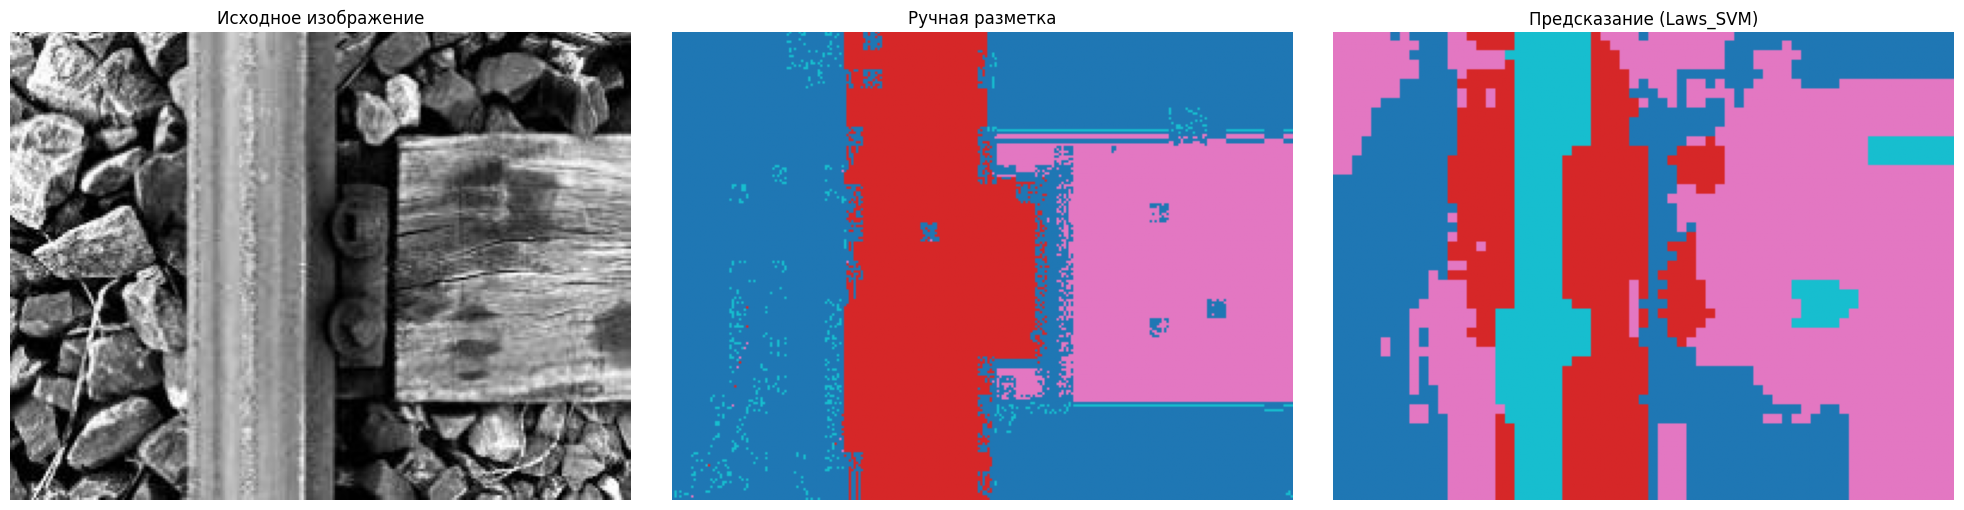

Итог: 56.1% правильных пикселей


In [65]:
print("Запускаем сегментацию...")
predicted_mask = segment_sandwich(
    selected_models['Laws_SVM'], 'Laws_SVM', rails_image_path,
    patch_size=32, step=4
)

if predicted_mask is not None:
    print(f"Предсказание: {predicted_mask.shape}")
    print(f"Уникальные классы в предсказании: {np.unique(predicted_mask)}")

    if fixed_manual_mask is not None and predicted_mask is not None and original_img is not None:
        accuracy = compare_simple(fixed_manual_mask, predicted_mask, 'Laws_SVM', original_img)
        print(f"Итог: {accuracy*100:.1f}% правильных пикселей")